In [12]:
import os
import sys
from os.path import join
import json

from tqdm import tqdm
import pandas as pd
import numpy as np
import nfl_data_py as nfl

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

with open("paths.json", 'r') as f:
    paths = json.load(f)

RAW_DATA_PATH = paths['raw_data']
PROCESSED_DATA_PATH = paths['processed_data']

In [13]:
# Load the non-tracking data
df_game = pd.read_csv(join(RAW_DATA_PATH, "games.csv"))
df_play = pd.read_csv(join(RAW_DATA_PATH, "plays.csv"))
df_player_play = pd.read_csv(join(RAW_DATA_PATH, "player_play.csv"))
df_player = pd.read_csv(join(RAW_DATA_PATH, "players.csv"))
df_teams = nfl.import_team_desc()

# Uncamelcase the columns
df_game = util.uncamelcase_columns(df_game)
df_player = util.uncamelcase_columns(df_player)
df_play = util.uncamelcase_columns(df_play)
df_player_play = util.uncamelcase_columns(df_player_play)

# Add game_play_id to the play and player_play dataframes
df_play.insert(
    loc=2, 
    column='game_play_id', 
    value=df_play['game_id'].astype(str) + '_' + df_play['play_id'].astype(str)
)
df_player_play.insert(
    loc=2, 
    column='game_play_id',
    value=df_player_play['game_id'].astype(str) + '_' + df_player_play['play_id'].astype(str)
)

# Load nfl-data-py PBP data
pbp_cols = [
    'old_game_id_x','play_id','run_location','rusher_player_id','offense_personnel',
    'defenders_in_box','defense_personnel','desc'
]
rename_dict = {'old_game_id_x': 'game_id'}
rusher_positions = ['RB','TE','WR','FB','HB']
df_pbp = (
    nfl.import_pbp_data([2022])
    .query(
        'penalty == 0 and ' + \
        'fumble == 0  and ' +\
        'play_type == "run" and ' +\
        'qb_scramble == 0 and ' +\
        'qb_dropback == 0 and ' +\
        'qb_kneel == 0 and ' +\
        'qb_spike == 0 and ' +\
        '~play_type.isna() and ' +\
        'n_offense == 11 and ' +\
        'n_defense == 11 and ' +\
        'two_point_attempt == 0'
    )[pbp_cols]
    .rename(rename_dict, axis=1)
    .assign(
        game_id=lambda x: x.game_id.astype(int),
        play_id=lambda x: x.play_id.astype(int)
    ).merge(
        nfl.import_seasonal_rosters(
            years=[2022],
            columns=[
                'player_id',
                'position'
            ]
        ),        
        left_on='rusher_player_id',
        right_on='player_id',
        how='left'
    ).query('position.isin(@rusher_positions)') # Remove QB runs (and one LB run )
    .drop(columns=['player_id','position','rusher_player_id'])
)

df_pbp = df_pbp[
    (df_pbp.desc.str.lower().str.contains('punt') == False) &
    (df_pbp.desc.str.lower().str.contains('penalty') == False) &
    (~df_pbp.offense_personnel.isna()) &
    (~df_pbp.defenders_in_box.isna())
].drop(['desc'],axis=1)

2022 done.
Downcasting floats.


In [14]:
df_pbp.head()

,game_id,play_id,run_location,offense_personnel,defenders_in_box,defense_personnel
0,2022091107,68,left,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB"
1,2022091107,115,left,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB"
3,2022091107,275,right,"2 RB, 2 TE, 1 WR",7.0,"4 DL, 3 LB, 4 DB"
4,2022091107,330,right,"2 RB, 2 TE, 1 WR",8.0,"3 DL, 4 LB, 4 DB"
5,2022091107,391,right,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB"


In [15]:
game_ids = []
game_play_ids = []

for wk in tqdm(range(1,10), desc="filtering & standardizing tracking data"):

    if not os.path.exists(join(PROCESSED_DATA_PATH, f'wk{wk}')):
        os.makedirs(join(PROCESSED_DATA_PATH, f'wk{wk}'))

    # load tracking data, filtering down to run plays which are not a qb run
    df_tracking = (
        util.uncamelcase_columns(
            pd.read_csv(join(RAW_DATA_PATH, f'tracking_week_{wk}.csv'))
        ).merge(
            df_pbp[[
                'game_id',
                'play_id',
                'run_location']
            ],
            on=['game_id','play_id'],
            how='left'
        ).dropna(
            subset=['run_location']
        ).drop(['run_location'],axis=1)
    )
    if 'week' not in df_tracking.columns:
        df_tracking.insert(3,'week',wk)

    # standardize direction to be offense moving right
    df_tracking, df_play_wk = util.standardize_direction(df_tracking, df_play)

    # Create single unique tracking data key
    df_tracking.insert(
        loc=2, 
        column='game_play_id', 
        value=df_tracking['game_id'].astype(str) + '_' + df_tracking['play_id'].astype(str) 
    )

    if df_play_wk.query('~((play_nullified_by_penalty == "N") and (penalty_yards != 0))').shape[0] > 0:
        raise ValueError('There are plays that were nullified by penalty or had penalty yards')

    df_tracking = df_tracking.merge(df_player[['nfl_id','position']], on='nfl_id', how='left')

    # add play info to tracking data
    df_tracking = df_tracking.merge(
        df_play_wk[['game_play_id','possession_team','absolute_yardline_number','yards_to_go']], 
        on=['game_play_id'], 
        how='left'
    )
    df_tracking['offense'] = df_tracking['club'] == df_tracking['possession_team']
    df_tracking['defense'] = ~df_tracking['offense'] & (df_tracking['club'] != 'football')
    df_tracking.drop(columns=['possession_team'], inplace=True)

    # create features of distance of players to ball
    tracking_ball = df_tracking[['game_play_id','frame_id','x','y','club']].query('club=="football"').copy()
    tracking_ball.rename(columns={'x':'ball_x','y':'ball_y'}, inplace=True)
    df_tracking = df_tracking.merge(
        tracking_ball[['game_play_id','frame_id','ball_x','ball_y']], 
        on=['game_play_id','frame_id'], 
        how='left'
    )
    del tracking_ball
    df_tracking['euclidean_dist_to_ball'] = np.sqrt((df_tracking['x'] - df_tracking['ball_x'])**2 + \
                                                    (df_tracking['y'] - df_tracking['ball_y'])**2)
    df_tracking['lateral_dist_to_ball'] = df_tracking['x'] - df_tracking['ball_x']
    df_tracking['vertical_dist_to_ball'] = df_tracking['y'] - df_tracking['ball_y']

    # Join pbp info to play data
    df_play_wk = df_play_wk.merge(
        df_pbp,
        on=['game_id','play_id'],
        how='left'
    )

    # Save the processed tracking data
    df_tracking.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'tracking.pkl'))
    df_play_wk.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))

    game_ids.extend(df_tracking['game_id'].unique())
    game_play_ids.extend(df_tracking['game_play_id'].unique())

game_ids = list(set(game_ids))
game_play_ids = list(set(game_play_ids))

df_game = df_game.query('game_id.isin(@game_ids)')
df_player_play = df_player_play.query('game_play_id.isin(@game_play_ids)')

filtering & standardizing tracking data: 100%|██████████| 9/9 [02:11<00:00, 14.56s/it]


In [19]:
# Split Games and Player Play data by week
for wk in range(1,10):
    (df_game.query('week==@wk')
        .to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl')))
    game_ids = df_game.query('week==@wk')['game_id'].unique()
    (df_player_play.query('game_id.isin(@game_ids)')
        .to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'player_play.pkl')))

# Save the data independent of week
df_player.to_pickle(join(PROCESSED_DATA_PATH, 'players.pkl'))
df_teams.to_pickle(join(PROCESSED_DATA_PATH, 'teams.pkl'))

In [20]:
for wk in range(1,10):
    df_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))
    n_non_run_plays = df_play[
        ~(df_play.play_description.str.contains('left guard')) &
        ~(df_play.play_description.str.contains('left tackle')) &
        ~(df_play.play_description.str.contains('right guard')) &
        ~(df_play.play_description.str.contains('right tackle')) &
        ~(df_play.play_description.str.contains('up the middle')) &
        ~(df_play.play_description.str.contains('right end')) &
        ~(df_play.play_description.str.contains('left end'))
    ].shape[0]
    print(f'Week {wk}: {n_non_run_plays} non-run plays')

Week 1: 0 non-run plays
Week 2: 0 non-run plays
Week 3: 0 non-run plays
Week 4: 0 non-run plays
Week 5: 0 non-run plays
Week 6: 0 non-run plays
Week 7: 0 non-run plays
Week 8: 0 non-run plays
Week 9: 0 non-run plays


In [21]:
for wk in range(1, 10):
    df_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))

    conditions = [
        df_play.play_description.str.contains('left guard', na=False),
        df_play.play_description.str.contains('left tackle', na=False),
        df_play.play_description.str.contains('right guard', na=False),
        df_play.play_description.str.contains('right tackle', na=False),
        df_play.play_description.str.contains('up the middle', na=False),
        df_play.play_description.str.contains('right end', na=False),
        df_play.play_description.str.contains('left end', na=False)
    ]
    choices = [
        'left_guard', 'left_tackle', 'right_guard', 
        'right_tackle', 'middle', 'right_end', 'left_end'
    ]

    df_play['run_location_desc'] = np.select(conditions, choices, default='non_run')

    if df_play.query('run_location_desc=="non_run"').shape[0] > 0:
        raise ValueError(f'There are plays that are not run plays for week {wk}')

    df_play.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))

In [22]:
drop_plays = {
    1: {
        'game_ids': [
            '2022091101',
            '2022091112'
        ],
        'game_play_ids': [
            '2022091101_1826',
            '2022091112_112', # ball snap timing off
        ]
    },
    2: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    3: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    4: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    5: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    6: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    7: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    8: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    },
    9: {
        'game_ids': [
        ],
        'game_play_ids': [
        ]
    }
}

for wk in range(1,10):
    drop_game_ids  = drop_plays[wk]['game_ids']
    if drop_game_ids:
        df_game = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
        df_game = df_game.query('~game_id.isin(@drop_game_ids)')
        df_game.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))

    drop_game_play_ids = drop_plays[wk]['game_play_ids']
    if drop_game_play_ids:
        df_tracking = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'tracking.pkl'))
        df_tracking = df_tracking.query('~game_play_id.isin(@drop_game_play_ids)')
        df_tracking.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'tracking.pkl'))

        df_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))
        df_play = df_play.query('~game_play_id.isin(@drop_game_play_ids)')
        df_play.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))

        df_player_play = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'player_play.pkl'))
        df_player_play = df_player_play.query('~game_play_id.isin(@drop_game_play_ids)')
        df_player_play.to_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'player_play.pkl'))

In [23]:
df_play_wk = pd.DataFrame()
for wk in range(1,10):
    df_play_wk = pd.concat([df_play_wk, pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play.pkl'))])

# Create the buckets and calculate the average EPA per bucket
df_play_wk['bucket'] = (df_play_wk['absolute_yardline_number'] // 1) * 1
epa_by_bucket = df_play_wk.groupby('bucket')['expected_points_added'].mean()
epa_by_bucket = epa_by_bucket.reset_index()

# smooth the expected points added with window size of 5
epa_by_bucket['smoothed_epa'] = epa_by_bucket['expected_points_added'].rolling(window=5, min_periods=1, center=True).mean()

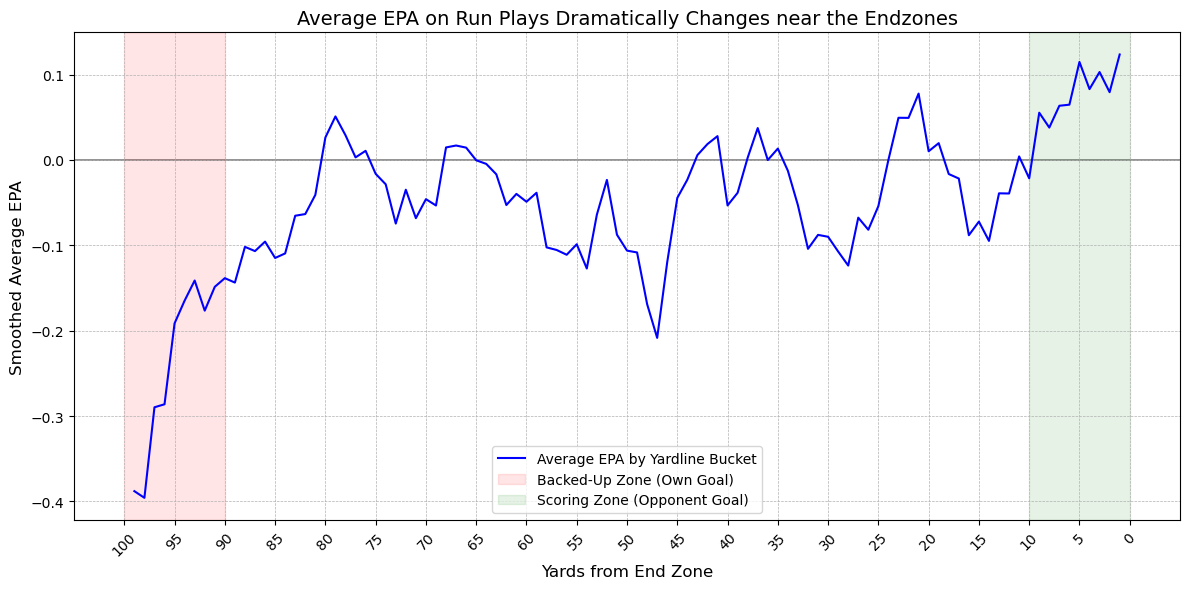

In [24]:
import matplotlib.pyplot as plt

x_labels = ['100', '95', '90', '85', '80', '75', '70', '65', '60', '55',
            '50', '45', '40', '35', '30', '25', '20', '15', '10', '5', '0']
x_ticks = np.arange(10, 111, 5)

# Plotting the data with updated labels and extended shading
plt.figure(figsize=(12, 6))
plt.plot(epa_by_bucket.bucket, epa_by_bucket.smoothed_epa, label='Average EPA by Yardline Bucket', color='blue')
plt.axhline(0, color='gray', linestyle='-', linewidth=1.2, zorder=0)

# Extend shading for first 10 yards (100-90) and last 10 yards (10-0)
plt.axvspan(10, 20, color='red', alpha=0.1, label='Backed-Up Zone (Own Goal)')
plt.axvspan(100, 110, color='green', alpha=0.1, label='Scoring Zone (Opponent Goal)')

# Adding labels, title, and legend
plt.title('Average EPA on Run Plays Dramatically Changes near the Endzones', fontsize=14)
plt.xlabel('Yards from End Zone', fontsize=12)
plt.ylabel('Smoothed Average EPA', fontsize=12)
plt.xticks(x_ticks, x_labels, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()